## ASSIGNMENT-2
## Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [ ]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [ ]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file.

In [ ]:
DATASET_URL = "https://gist.github.com/BirajCoder/5f068dfe759c1ea6bdfce9535acdb72d/raw/c84d84e3c80f93be67f6c069cbdc0195ec36acbd/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

  0%|          | 0/54288 [00:00<?, ?it/s]

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [ ]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [ ]:
your_name = 'Praveena' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [ ]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [ ]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
240,23,female,41.8038,2,yes,northeast,37356.279451
651,53,female,45.1440,1,no,southeast,10262.319670
761,23,male,40.1280,1,no,southwest,2344.446350
836,36,male,35.9100,0,no,southwest,4270.166010
1147,20,female,36.3888,0,no,northwest,2193.721736


Let us answer some basic questions about the dataset.


**Q1: How many rows does the dataset have?**

In [ ]:
num_rows = dataframe.index.size
print(num_rows)

1271


**Q2: How many columns does the dataset have**

In [ ]:
num_cols = dataframe.columns.size
print(num_cols)

7


**Q3: What are the column titles of the input variables?**

In [ ]:
input_cols = dataframe.columns[0:-1]
input_cols

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

**Q4: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [ ]:
categorical_cols = ['sex','smoker','region']
dataframe.head()[categorical_cols]

,sex,smoker,region
240,female,yes,northeast
651,female,no,southeast
761,male,no,southwest
836,male,no,southwest
1147,female,no,northwest


**Q5: What are the column titles of output/target variable(s)?**

In [ ]:
output_cols = ['charges']
dataframe.head()[output_cols]

,charges
240,37356.279451
651,10262.319670
761,2344.446350
836,4270.166010
1147,2193.721736


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ai/aakashns/dataviz-cheatsheet

In [ ]:
total = dataframe[output_cols].sum()
average_charge = total / dataframe.index.size
average_charge

charges    12972.222716
dtype: float64

In [ ]:
dataframe[output_cols].mean()

charges    12972.222716
dtype: float64

In [ ]:
print('Minimum', dataframe[output_cols].min())
print('Maximum', dataframe[output_cols].max())

Minimum charges    1088.217683
dtype: float64
Maximum charges    61857.31517
dtype: float64


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


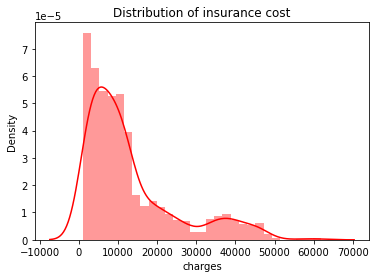

In [ ]:
plt.title("Distribution of insurance cost")

sns.distplot(dataframe.charges,color='red');

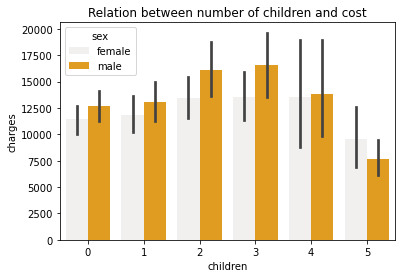

In [ ]:
plt.title("Relation between number of children and cost")
sns.barplot(x="children", y="charges", hue="sex", data=dataframe,color='orange');

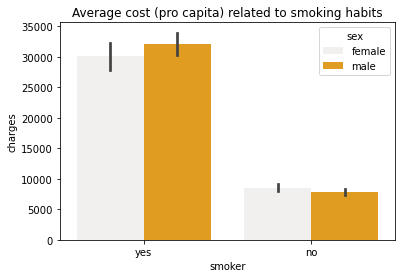

In [ ]:
plt.title("Average cost (pro capita) related to smoking habits")
sns.barplot(x="smoker", y="charges", hue="sex", data=dataframe,color='orange');

In [ ]:
!pip install jovian --upgrade -q

In [ ]:
import jovian

In [ ]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "praveenamuthukumar2511/02-insurance-linear-regression" on https://jovian.com
[jovian] Committed successfully! https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression


'https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [ ]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array.shape,inputs_array, targets_array

((1271, 6),
 array([[23.    ,  0.    , 41.8038,  2.    ,  1.    ,  0.    ],
        [53.    ,  0.    , 45.144 ,  1.    ,  0.    ,  2.    ],
        [23.    ,  1.    , 40.128 ,  1.    ,  0.    ,  3.    ],
        ...,
        [59.    ,  0.    , 41.9121,  1.    ,  1.    ,  0.    ],
        [53.    ,  0.    , 37.905 ,  0.    ,  0.    ,  0.    ],
        [48.    ,  0.    , 37.9962,  0.    ,  0.    ,  2.    ]]),
 array([[37356.279451 ],
        [10262.31967  ],
        [ 2344.44635  ],
        ...,
        [46459.8876095],
        [10247.937965 ],
        [ 8035.170279 ]]))

**Q6: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [ ]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)

In [ ]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [ ]:
dataset = TensorDataset(inputs, targets)

**Q7: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [ ]:
val_percent =0.1712 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q8: Pick a batch size for the data loader.**

In [ ]:
batch_size = 2**8

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [ ]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[33.0000,  1.0000, 28.0497,  2.0000,  0.0000,  1.0000],
        [37.0000,  1.0000, 42.2598,  1.0000,  1.0000,  2.0000],
        [56.0000,  1.0000, 45.9420,  0.0000,  0.0000,  3.0000],
        ...,
        [36.0000,  0.0000, 33.1056,  4.0000,  0.0000,  2.0000],
        [52.0000,  0.0000, 42.6360,  0.0000,  0.0000,  3.0000],
        [22.0000,  1.0000, 59.9412,  1.0000,  1.0000,  2.0000]])
targets: tensor([[ 5099.7827],
        [38675.5547],
        [10284.3135],
        [ 5929.8340],
        [11901.5977],
        [ 9413.5283],
        [11323.9062],
        [11410.1113],
        [13826.9697],
        [ 1590.3762],
        [29352.1953],
        [ 5756.3486],
        [ 3451.8616],
        [ 6945.5205],
        [37628.9062],
        [ 8972.0107],
        [ 3593.2239],
        [ 8345.7090],
        [11012.6309],
        [ 9329.1328],
        [26401.8848],
        [14251.8896],
        [47062.0352],
        [14134.7344],
        [ 1657.6580],
        [ 2884.9021],
        [ 827

Let's save our work by committing to Jovian.

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "praveenamuthukumar2511/02-insurance-linear-regression" on https://jovian.com
[jovian] Committed successfully! https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression


'https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment).


In [ ]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q9: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [ ]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear =  nn.Linear(input_size, output_size)                # fill this (hint: use input_size & output_size defined above)

    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out

    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calcuate loss
        loss = F.l1_loss(out, targets)                     # fill this
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [ ]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2020,  0.0091,  0.2094, -0.0278,  0.2717,  0.1458]],
        requires_grad=True),
 Parameter containing:
 tensor([0.0874], requires_grad=True)]

One final commit before we train the model.

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "praveenamuthukumar2511/02-insurance-linear-regression" on https://jovian.com
[jovian] Committed successfully! https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression


'https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q10: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [ ]:
result =  evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13302.6708984375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q11: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [ ]:
epochs = 100
lr = 2e-1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6958.4106
Epoch [40], val_loss: 6736.3179
Epoch [60], val_loss: 6636.5137
Epoch [80], val_loss: 6600.9868
Epoch [100], val_loss: 6602.2441


In [ ]:
epochs = 5000
lr = 1.5e-1
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6593.2212
Epoch [40], val_loss: 6591.0083
Epoch [60], val_loss: 6592.9487
Epoch [80], val_loss: 6588.3003
Epoch [100], val_loss: 6592.5283
Epoch [120], val_loss: 6587.7222
Epoch [140], val_loss: 6586.0215
Epoch [160], val_loss: 6583.7139
Epoch [180], val_loss: 6582.1982
Epoch [200], val_loss: 6586.2661
Epoch [220], val_loss: 6576.7329
Epoch [240], val_loss: 6575.6919
Epoch [260], val_loss: 6576.9990
Epoch [280], val_loss: 6572.8843
Epoch [300], val_loss: 6571.0596
Epoch [320], val_loss: 6572.1914
Epoch [340], val_loss: 6573.6406
Epoch [360], val_loss: 6567.8296
Epoch [380], val_loss: 6565.5283
Epoch [400], val_loss: 6568.1211
Epoch [420], val_loss: 6562.8813
Epoch [440], val_loss: 6564.0869
Epoch [460], val_loss: 6559.9355
Epoch [480], val_loss: 6558.2568
Epoch [500], val_loss: 6558.6689
Epoch [520], val_loss: 6564.9927
Epoch [540], val_loss: 6554.4595
Epoch [560], val_loss: 6553.8486
Epoch [580], val_loss: 6552.6592
Epoch [600], val_loss: 6560.9863
Epoch [620], v

Epoch [4900], val_loss: 6395.4253
Epoch [4920], val_loss: 6395.2812
Epoch [4940], val_loss: 6391.2529
Epoch [4960], val_loss: 6390.2812
Epoch [4980], val_loss: 6390.3716
Epoch [5000], val_loss: 6389.2251


In [ ]:
epochs = 50000
lr = 8e-2
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6388.5811
Epoch [40], val_loss: 6388.2715
Epoch [60], val_loss: 6392.8115
Epoch [80], val_loss: 6387.7852
Epoch [100], val_loss: 6389.0732
Epoch [120], val_loss: 6386.9595
Epoch [140], val_loss: 6388.0322
Epoch [160], val_loss: 6386.3550
Epoch [180], val_loss: 6385.9932
Epoch [200], val_loss: 6385.3481
Epoch [220], val_loss: 6385.0571
Epoch [240], val_loss: 6386.1680
Epoch [260], val_loss: 6384.1719
Epoch [280], val_loss: 6383.7446
Epoch [300], val_loss: 6385.1152
Epoch [320], val_loss: 6383.8662
Epoch [340], val_loss: 6383.6323
Epoch [360], val_loss: 6382.3525
Epoch [380], val_loss: 6382.6821
Epoch [400], val_loss: 6381.4834
Epoch [420], val_loss: 6381.5093
Epoch [440], val_loss: 6380.6689
Epoch [460], val_loss: 6382.6719
Epoch [480], val_loss: 6380.4771
Epoch [500], val_loss: 6379.4297
Epoch [520], val_loss: 6378.9849
Epoch [540], val_loss: 6379.4810
Epoch [560], val_loss: 6378.9468
Epoch [580], val_loss: 6378.2627
Epoch [600], val_loss: 6381.0483
Epoch [620], v

Epoch [4900], val_loss: 6295.0981
Epoch [4920], val_loss: 6294.8335
Epoch [4940], val_loss: 6294.1719
Epoch [4960], val_loss: 6296.2886
Epoch [4980], val_loss: 6293.3340
Epoch [5000], val_loss: 6293.1543
Epoch [5020], val_loss: 6295.1416
Epoch [5040], val_loss: 6292.1772
Epoch [5060], val_loss: 6291.8374
Epoch [5080], val_loss: 6292.8203
Epoch [5100], val_loss: 6291.0356
Epoch [5120], val_loss: 6291.0024
Epoch [5140], val_loss: 6290.7295
Epoch [5160], val_loss: 6289.9873
Epoch [5180], val_loss: 6292.0215
Epoch [5200], val_loss: 6289.1890
Epoch [5220], val_loss: 6290.3428
Epoch [5240], val_loss: 6288.5137
Epoch [5260], val_loss: 6290.2930
Epoch [5280], val_loss: 6287.6157
Epoch [5300], val_loss: 6287.9399
Epoch [5320], val_loss: 6286.9062
Epoch [5340], val_loss: 6286.7339
Epoch [5360], val_loss: 6286.2959
Epoch [5380], val_loss: 6285.7183
Epoch [5400], val_loss: 6286.1069
Epoch [5420], val_loss: 6285.0640
Epoch [5440], val_loss: 6284.5522
Epoch [5460], val_loss: 6284.1382
Epoch [5480], 

Epoch [9740], val_loss: 6203.0083
Epoch [9760], val_loss: 6206.6294
Epoch [9780], val_loss: 6202.3979
Epoch [9800], val_loss: 6201.9360
Epoch [9820], val_loss: 6201.5967
Epoch [9840], val_loss: 6202.2534
Epoch [9860], val_loss: 6200.8428
Epoch [9880], val_loss: 6200.4868
Epoch [9900], val_loss: 6200.4736
Epoch [9920], val_loss: 6199.6353
Epoch [9940], val_loss: 6199.2656
Epoch [9960], val_loss: 6199.0664
Epoch [9980], val_loss: 6198.6694
Epoch [10000], val_loss: 6198.3711
Epoch [10020], val_loss: 6197.7417
Epoch [10040], val_loss: 6198.4941
Epoch [10060], val_loss: 6197.5557
Epoch [10080], val_loss: 6196.5898
Epoch [10100], val_loss: 6196.2583
Epoch [10120], val_loss: 6196.4380
Epoch [10140], val_loss: 6195.7358
Epoch [10160], val_loss: 6195.2886
Epoch [10180], val_loss: 6194.7305
Epoch [10200], val_loss: 6194.3101
Epoch [10220], val_loss: 6193.8530
Epoch [10240], val_loss: 6193.5713
Epoch [10260], val_loss: 6193.3647
Epoch [10280], val_loss: 6193.6987
Epoch [10300], val_loss: 6193.330

Epoch [14520], val_loss: 6112.9492
Epoch [14540], val_loss: 6112.5576
Epoch [14560], val_loss: 6112.0356
Epoch [14580], val_loss: 6111.8857
Epoch [14600], val_loss: 6111.3955
Epoch [14620], val_loss: 6112.0430
Epoch [14640], val_loss: 6110.5068
Epoch [14660], val_loss: 6110.1069
Epoch [14680], val_loss: 6110.0557
Epoch [14700], val_loss: 6109.4771
Epoch [14720], val_loss: 6109.2725
Epoch [14740], val_loss: 6108.5845
Epoch [14760], val_loss: 6110.4644
Epoch [14780], val_loss: 6107.8193
Epoch [14800], val_loss: 6107.4736
Epoch [14820], val_loss: 6107.0967
Epoch [14840], val_loss: 6107.0649
Epoch [14860], val_loss: 6107.2974
Epoch [14880], val_loss: 6105.9873
Epoch [14900], val_loss: 6106.2588
Epoch [14920], val_loss: 6105.7393
Epoch [14940], val_loss: 6105.3052
Epoch [14960], val_loss: 6104.5000
Epoch [14980], val_loss: 6104.6982
Epoch [15000], val_loss: 6104.1436
Epoch [15020], val_loss: 6103.4346
Epoch [15040], val_loss: 6103.2246
Epoch [15060], val_loss: 6102.9243
Epoch [15080], val_l

Epoch [19220], val_loss: 6028.0854
Epoch [19240], val_loss: 6025.1147
Epoch [19260], val_loss: 6025.9517
Epoch [19280], val_loss: 6024.1494
Epoch [19300], val_loss: 6023.8945
Epoch [19320], val_loss: 6023.6479
Epoch [19340], val_loss: 6023.0200
Epoch [19360], val_loss: 6025.2793
Epoch [19380], val_loss: 6022.4292
Epoch [19400], val_loss: 6021.9785
Epoch [19420], val_loss: 6021.3726
Epoch [19440], val_loss: 6022.8208
Epoch [19460], val_loss: 6020.7432
Epoch [19480], val_loss: 6020.5728
Epoch [19500], val_loss: 6020.0972
Epoch [19520], val_loss: 6020.2168
Epoch [19540], val_loss: 6020.2656
Epoch [19560], val_loss: 6019.0503
Epoch [19580], val_loss: 6018.6470
Epoch [19600], val_loss: 6019.0967
Epoch [19620], val_loss: 6017.8340
Epoch [19640], val_loss: 6018.6094
Epoch [19660], val_loss: 6018.9141
Epoch [19680], val_loss: 6016.7129
Epoch [19700], val_loss: 6016.5234
Epoch [19720], val_loss: 6017.6079
Epoch [19740], val_loss: 6015.6997
Epoch [19760], val_loss: 6015.5571
Epoch [19780], val_l

Epoch [23920], val_loss: 5938.8691
Epoch [23940], val_loss: 5939.4658
Epoch [23960], val_loss: 5937.4551
Epoch [23980], val_loss: 5939.0483
Epoch [24000], val_loss: 5937.1934
Epoch [24020], val_loss: 5936.4385
Epoch [24040], val_loss: 5935.6372
Epoch [24060], val_loss: 5937.3848
Epoch [24080], val_loss: 5936.3457
Epoch [24100], val_loss: 5938.5264
Epoch [24120], val_loss: 5936.9009
Epoch [24140], val_loss: 5934.1167
Epoch [24160], val_loss: 5933.5693
Epoch [24180], val_loss: 5934.1655
Epoch [24200], val_loss: 5935.5923
Epoch [24220], val_loss: 5932.5483
Epoch [24240], val_loss: 5933.5342
Epoch [24260], val_loss: 5932.4946
Epoch [24280], val_loss: 5932.9136
Epoch [24300], val_loss: 5931.8813
Epoch [24320], val_loss: 5932.4688
Epoch [24340], val_loss: 5930.4780
Epoch [24360], val_loss: 5933.0615
Epoch [24380], val_loss: 5929.7944
Epoch [24400], val_loss: 5930.9766
Epoch [24420], val_loss: 5930.1963
Epoch [24440], val_loss: 5929.0137
Epoch [24460], val_loss: 5928.0664
Epoch [24480], val_l

Epoch [28640], val_loss: 5852.1895
Epoch [28660], val_loss: 5852.1548
Epoch [28680], val_loss: 5850.8955
Epoch [28700], val_loss: 5850.4419
Epoch [28720], val_loss: 5851.3066
Epoch [28740], val_loss: 5851.5806
Epoch [28760], val_loss: 5851.6680
Epoch [28780], val_loss: 5851.4238
Epoch [28800], val_loss: 5848.7510
Epoch [28820], val_loss: 5848.3789
Epoch [28840], val_loss: 5848.8848
Epoch [28860], val_loss: 5848.4868
Epoch [28880], val_loss: 5848.1416
Epoch [28900], val_loss: 5850.6348
Epoch [28920], val_loss: 5847.0425
Epoch [28940], val_loss: 5846.4253
Epoch [28960], val_loss: 5846.0693
Epoch [28980], val_loss: 5845.7310
Epoch [29000], val_loss: 5846.9717
Epoch [29020], val_loss: 5845.8472
Epoch [29040], val_loss: 5848.2358
Epoch [29060], val_loss: 5843.7871
Epoch [29080], val_loss: 5845.0518
Epoch [29100], val_loss: 5846.2407
Epoch [29120], val_loss: 5848.6157
Epoch [29140], val_loss: 5842.2017
Epoch [29160], val_loss: 5842.5742
Epoch [29180], val_loss: 5842.1450
Epoch [29200], val_l

Epoch [33340], val_loss: 5768.7505
Epoch [33360], val_loss: 5769.5474
Epoch [33380], val_loss: 5765.5063
Epoch [33400], val_loss: 5768.5425
Epoch [33420], val_loss: 5766.3623
Epoch [33440], val_loss: 5764.5083
Epoch [33460], val_loss: 5763.9614
Epoch [33480], val_loss: 5764.6152
Epoch [33500], val_loss: 5764.7275
Epoch [33520], val_loss: 5763.2559
Epoch [33540], val_loss: 5762.7344
Epoch [33560], val_loss: 5767.1421
Epoch [33580], val_loss: 5762.1050
Epoch [33600], val_loss: 5761.3535
Epoch [33620], val_loss: 5761.6089
Epoch [33640], val_loss: 5760.5083
Epoch [33660], val_loss: 5760.1787
Epoch [33680], val_loss: 5759.9829
Epoch [33700], val_loss: 5759.6646
Epoch [33720], val_loss: 5759.5000
Epoch [33740], val_loss: 5760.4155
Epoch [33760], val_loss: 5763.9272
Epoch [33780], val_loss: 5758.5093
Epoch [33800], val_loss: 5757.5537
Epoch [33820], val_loss: 5758.2920
Epoch [33840], val_loss: 5757.1030
Epoch [33860], val_loss: 5759.6689
Epoch [33880], val_loss: 5756.9058
Epoch [33900], val_l

Epoch [38040], val_loss: 5680.9331
Epoch [38060], val_loss: 5682.4653
Epoch [38080], val_loss: 5681.0068
Epoch [38100], val_loss: 5682.5703
Epoch [38120], val_loss: 5679.5127
Epoch [38140], val_loss: 5679.4561
Epoch [38160], val_loss: 5678.7783
Epoch [38180], val_loss: 5679.7393
Epoch [38200], val_loss: 5678.5513
Epoch [38220], val_loss: 5678.5264
Epoch [38240], val_loss: 5677.7524
Epoch [38260], val_loss: 5677.0293
Epoch [38280], val_loss: 5676.6099
Epoch [38300], val_loss: 5676.2817
Epoch [38320], val_loss: 5680.9194
Epoch [38340], val_loss: 5675.3281
Epoch [38360], val_loss: 5675.1860
Epoch [38380], val_loss: 5675.1816
Epoch [38400], val_loss: 5674.7070
Epoch [38420], val_loss: 5675.8135
Epoch [38440], val_loss: 5673.8726
Epoch [38460], val_loss: 5673.1514
Epoch [38480], val_loss: 5672.9346
Epoch [38500], val_loss: 5673.3237
Epoch [38520], val_loss: 5672.0791
Epoch [38540], val_loss: 5671.6279
Epoch [38560], val_loss: 5671.6377
Epoch [38580], val_loss: 5671.4883
Epoch [38600], val_l

Epoch [42760], val_loss: 5596.1050
Epoch [42780], val_loss: 5595.6733
Epoch [42800], val_loss: 5595.0918
Epoch [42820], val_loss: 5596.8857
Epoch [42840], val_loss: 5594.7231
Epoch [42860], val_loss: 5594.9346
Epoch [42880], val_loss: 5594.4126
Epoch [42900], val_loss: 5594.6934
Epoch [42920], val_loss: 5593.6636
Epoch [42940], val_loss: 5593.4570
Epoch [42960], val_loss: 5592.9429
Epoch [42980], val_loss: 5596.8491
Epoch [43000], val_loss: 5592.9307
Epoch [43020], val_loss: 5597.0391
Epoch [43040], val_loss: 5591.1475
Epoch [43060], val_loss: 5590.6348
Epoch [43080], val_loss: 5591.7671
Epoch [43100], val_loss: 5590.4019
Epoch [43120], val_loss: 5590.9482
Epoch [43140], val_loss: 5589.1533
Epoch [43160], val_loss: 5588.9932
Epoch [43180], val_loss: 5588.9819
Epoch [43200], val_loss: 5589.3389
Epoch [43220], val_loss: 5589.2690
Epoch [43240], val_loss: 5587.2529
Epoch [43260], val_loss: 5587.3696
Epoch [43280], val_loss: 5586.4243
Epoch [43300], val_loss: 5586.8911
Epoch [43320], val_l

Epoch [47460], val_loss: 5511.6030
Epoch [47480], val_loss: 5512.1982
Epoch [47500], val_loss: 5511.0444
Epoch [47520], val_loss: 5511.8584
Epoch [47540], val_loss: 5512.5854
Epoch [47560], val_loss: 5512.8174
Epoch [47580], val_loss: 5510.2812
Epoch [47600], val_loss: 5510.2524
Epoch [47620], val_loss: 5508.8086
Epoch [47640], val_loss: 5509.7168
Epoch [47660], val_loss: 5509.1348
Epoch [47680], val_loss: 5507.7183
Epoch [47700], val_loss: 5512.3154
Epoch [47720], val_loss: 5507.1440
Epoch [47740], val_loss: 5506.6675
Epoch [47760], val_loss: 5506.2944
Epoch [47780], val_loss: 5508.3564
Epoch [47800], val_loss: 5507.3101
Epoch [47820], val_loss: 5506.4395
Epoch [47840], val_loss: 5505.3457
Epoch [47860], val_loss: 5504.6406
Epoch [47880], val_loss: 5504.6191
Epoch [47900], val_loss: 5503.9282
Epoch [47920], val_loss: 5503.5566
Epoch [47940], val_loss: 5503.2539
Epoch [47960], val_loss: 5502.7974
Epoch [47980], val_loss: 5503.3770
Epoch [48000], val_loss: 5502.8013
Epoch [48020], val_l

In [ ]:
epochs = 10000
lr = 9.5e-2
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5465.9414
Epoch [40], val_loss: 5465.5693
Epoch [60], val_loss: 5465.0957
Epoch [80], val_loss: 5464.7124
Epoch [100], val_loss: 5464.7280
Epoch [120], val_loss: 5464.7876
Epoch [140], val_loss: 5463.3901
Epoch [160], val_loss: 5463.2510
Epoch [180], val_loss: 5463.1592
Epoch [200], val_loss: 5463.0327
Epoch [220], val_loss: 5462.1704
Epoch [240], val_loss: 5461.3354
Epoch [260], val_loss: 5462.7788
Epoch [280], val_loss: 5463.7637
Epoch [300], val_loss: 5462.4097
Epoch [320], val_loss: 5459.6211
Epoch [340], val_loss: 5462.1162
Epoch [360], val_loss: 5459.9785
Epoch [380], val_loss: 5458.3550
Epoch [400], val_loss: 5459.5630
Epoch [420], val_loss: 5457.6304
Epoch [440], val_loss: 5457.0728
Epoch [460], val_loss: 5456.8198
Epoch [480], val_loss: 5456.3628
Epoch [500], val_loss: 5455.8340
Epoch [520], val_loss: 5456.9014
Epoch [540], val_loss: 5454.8911
Epoch [560], val_loss: 5454.5405
Epoch [580], val_loss: 5455.7349
Epoch [600], val_loss: 5455.5278
Epoch [620], v

Epoch [4900], val_loss: 5363.1484
Epoch [4920], val_loss: 5362.5952
Epoch [4940], val_loss: 5362.9072
Epoch [4960], val_loss: 5362.6143
Epoch [4980], val_loss: 5361.2534
Epoch [5000], val_loss: 5360.8979
Epoch [5020], val_loss: 5360.5449
Epoch [5040], val_loss: 5360.0229
Epoch [5060], val_loss: 5359.5615
Epoch [5080], val_loss: 5360.8257
Epoch [5100], val_loss: 5361.4146
Epoch [5120], val_loss: 5359.7798
Epoch [5140], val_loss: 5359.1885
Epoch [5160], val_loss: 5358.8052
Epoch [5180], val_loss: 5357.1274
Epoch [5200], val_loss: 5358.8564
Epoch [5220], val_loss: 5356.1831
Epoch [5240], val_loss: 5356.8770
Epoch [5260], val_loss: 5358.0703
Epoch [5280], val_loss: 5355.0269
Epoch [5300], val_loss: 5359.7690
Epoch [5320], val_loss: 5354.4805
Epoch [5340], val_loss: 5354.4517
Epoch [5360], val_loss: 5353.3657
Epoch [5380], val_loss: 5355.7104
Epoch [5400], val_loss: 5352.3628
Epoch [5420], val_loss: 5353.0806
Epoch [5440], val_loss: 5352.2246
Epoch [5460], val_loss: 5354.1543
Epoch [5480], 

Epoch [9720], val_loss: 5262.7339
Epoch [9740], val_loss: 5261.4077
Epoch [9760], val_loss: 5261.1621
Epoch [9780], val_loss: 5266.6250
Epoch [9800], val_loss: 5260.7627
Epoch [9820], val_loss: 5259.6465
Epoch [9840], val_loss: 5259.5376
Epoch [9860], val_loss: 5260.2207
Epoch [9880], val_loss: 5259.8618
Epoch [9900], val_loss: 5257.8501
Epoch [9920], val_loss: 5258.0063
Epoch [9940], val_loss: 5258.3950
Epoch [9960], val_loss: 5258.7598
Epoch [9980], val_loss: 5256.2783
Epoch [10000], val_loss: 5258.7661


In [ ]:
epochs = 50000
lr =7e-2
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 4495.5200
Epoch [40], val_loss: 4495.0874
Epoch [60], val_loss: 4495.2500
Epoch [80], val_loss: 4494.8169
Epoch [100], val_loss: 4495.5220
Epoch [120], val_loss: 4493.8369
Epoch [140], val_loss: 4495.5630
Epoch [160], val_loss: 4494.3359
Epoch [180], val_loss: 4496.6665
Epoch [200], val_loss: 4494.5000
Epoch [220], val_loss: 4492.5088
Epoch [240], val_loss: 4492.0508
Epoch [260], val_loss: 4492.0405
Epoch [280], val_loss: 4491.6860
Epoch [300], val_loss: 4492.5171
Epoch [320], val_loss: 4493.6016
Epoch [340], val_loss: 4490.5952
Epoch [360], val_loss: 4490.4199
Epoch [380], val_loss: 4491.3296
Epoch [400], val_loss: 4491.8438
Epoch [420], val_loss: 4489.4575
Epoch [440], val_loss: 4489.6304
Epoch [460], val_loss: 4488.9727
Epoch [480], val_loss: 4488.9058
Epoch [500], val_loss: 4488.4370
Epoch [520], val_loss: 4490.2231
Epoch [540], val_loss: 4488.1172
Epoch [560], val_loss: 4487.7827
Epoch [580], val_loss: 4487.8101
Epoch [600], val_loss: 4487.2280
Epoch [620], v

Epoch [4900], val_loss: 4431.8706
Epoch [4920], val_loss: 4430.8438
Epoch [4940], val_loss: 4430.0239
Epoch [4960], val_loss: 4431.2559
Epoch [4980], val_loss: 4429.5786
Epoch [5000], val_loss: 4428.9795
Epoch [5020], val_loss: 4430.8755
Epoch [5040], val_loss: 4428.6318
Epoch [5060], val_loss: 4428.4180
Epoch [5080], val_loss: 4428.0508
Epoch [5100], val_loss: 4428.1182
Epoch [5120], val_loss: 4427.7124
Epoch [5140], val_loss: 4427.3125
Epoch [5160], val_loss: 4427.4590
Epoch [5180], val_loss: 4426.6777
Epoch [5200], val_loss: 4427.8594
Epoch [5220], val_loss: 4426.0200
Epoch [5240], val_loss: 4427.5615
Epoch [5260], val_loss: 4425.7173
Epoch [5280], val_loss: 4425.5542
Epoch [5300], val_loss: 4425.6182
Epoch [5320], val_loss: 4425.1309
Epoch [5340], val_loss: 4426.5312
Epoch [5360], val_loss: 4424.6401
Epoch [5380], val_loss: 4424.8076
Epoch [5400], val_loss: 4424.7939
Epoch [5420], val_loss: 4423.8638
Epoch [5440], val_loss: 4424.1631
Epoch [5460], val_loss: 4425.8008
Epoch [5480], 

Epoch [9740], val_loss: 4368.5151
Epoch [9760], val_loss: 4369.4868
Epoch [9780], val_loss: 4368.1191
Epoch [9800], val_loss: 4368.9312
Epoch [9820], val_loss: 4368.3872
Epoch [9840], val_loss: 4368.1821
Epoch [9860], val_loss: 4367.4600
Epoch [9880], val_loss: 4367.6162
Epoch [9900], val_loss: 4368.4707
Epoch [9920], val_loss: 4367.9224
Epoch [9940], val_loss: 4366.0532
Epoch [9960], val_loss: 4365.9810
Epoch [9980], val_loss: 4366.7329
Epoch [10000], val_loss: 4365.8843
Epoch [10020], val_loss: 4365.6372
Epoch [10040], val_loss: 4365.3657
Epoch [10060], val_loss: 4364.9521
Epoch [10080], val_loss: 4364.6821
Epoch [10100], val_loss: 4365.8125
Epoch [10120], val_loss: 4364.2373
Epoch [10140], val_loss: 4365.2612
Epoch [10160], val_loss: 4363.1968
Epoch [10180], val_loss: 4363.3633
Epoch [10200], val_loss: 4362.7383
Epoch [10220], val_loss: 4362.5566
Epoch [10240], val_loss: 4362.3008
Epoch [10260], val_loss: 4363.0518
Epoch [10280], val_loss: 4361.6021
Epoch [10300], val_loss: 4361.651

Epoch [14440], val_loss: 4310.8921
Epoch [14460], val_loss: 4310.0903
Epoch [14480], val_loss: 4311.9385
Epoch [14500], val_loss: 4309.7930
Epoch [14520], val_loss: 4310.5010
Epoch [14540], val_loss: 4310.0068
Epoch [14560], val_loss: 4309.7515
Epoch [14580], val_loss: 4308.9575
Epoch [14600], val_loss: 4309.4497
Epoch [14620], val_loss: 4309.1929
Epoch [14640], val_loss: 4310.1670
Epoch [14660], val_loss: 4307.8667
Epoch [14680], val_loss: 4307.7417
Epoch [14700], val_loss: 4310.1724
Epoch [14720], val_loss: 4306.8125
Epoch [14740], val_loss: 4307.7192
Epoch [14760], val_loss: 4307.7217
Epoch [14780], val_loss: 4308.1001
Epoch [14800], val_loss: 4306.2041
Epoch [14820], val_loss: 4305.9541
Epoch [14840], val_loss: 4305.7373
Epoch [14860], val_loss: 4305.0020
Epoch [14880], val_loss: 4305.3276
Epoch [14900], val_loss: 4305.4595
Epoch [14920], val_loss: 4304.3232
Epoch [14940], val_loss: 4304.0918
Epoch [14960], val_loss: 4304.8945
Epoch [14980], val_loss: 4303.6440
Epoch [15000], val_l

Epoch [19140], val_loss: 4254.7295
Epoch [19160], val_loss: 4254.7832
Epoch [19180], val_loss: 4254.5039
Epoch [19200], val_loss: 4253.6270
Epoch [19220], val_loss: 4257.1597
Epoch [19240], val_loss: 4253.4561
Epoch [19260], val_loss: 4253.1606
Epoch [19280], val_loss: 4254.1494
Epoch [19300], val_loss: 4252.5220
Epoch [19320], val_loss: 4253.3325
Epoch [19340], val_loss: 4251.8096
Epoch [19360], val_loss: 4251.4385
Epoch [19380], val_loss: 4252.3667
Epoch [19400], val_loss: 4251.7407
Epoch [19420], val_loss: 4251.5557
Epoch [19440], val_loss: 4250.8867
Epoch [19460], val_loss: 4250.7856
Epoch [19480], val_loss: 4250.7544
Epoch [19500], val_loss: 4250.8794
Epoch [19520], val_loss: 4249.2251
Epoch [19540], val_loss: 4248.9497
Epoch [19560], val_loss: 4248.8325
Epoch [19580], val_loss: 4249.1284
Epoch [19600], val_loss: 4248.6294
Epoch [19620], val_loss: 4249.9365
Epoch [19640], val_loss: 4248.2832
Epoch [19660], val_loss: 4247.9546
Epoch [19680], val_loss: 4247.6284
Epoch [19700], val_l

Epoch [23860], val_loss: 4199.3613
Epoch [23880], val_loss: 4198.4893
Epoch [23900], val_loss: 4198.3906
Epoch [23920], val_loss: 4199.3340
Epoch [23940], val_loss: 4197.6675
Epoch [23960], val_loss: 4197.6851
Epoch [23980], val_loss: 4197.3101
Epoch [24000], val_loss: 4197.0171
Epoch [24020], val_loss: 4197.6431
Epoch [24040], val_loss: 4196.5181
Epoch [24060], val_loss: 4199.0913
Epoch [24080], val_loss: 4196.8887
Epoch [24100], val_loss: 4195.9927
Epoch [24120], val_loss: 4197.9702
Epoch [24140], val_loss: 4196.3486
Epoch [24160], val_loss: 4195.5396
Epoch [24180], val_loss: 4195.6533
Epoch [24200], val_loss: 4194.7559
Epoch [24220], val_loss: 4194.8467
Epoch [24240], val_loss: 4194.5801
Epoch [24260], val_loss: 4194.2563
Epoch [24280], val_loss: 4194.4692
Epoch [24300], val_loss: 4193.9668
Epoch [24320], val_loss: 4193.0161
Epoch [24340], val_loss: 4192.9893
Epoch [24360], val_loss: 4192.8105
Epoch [24380], val_loss: 4201.0293
Epoch [24400], val_loss: 4192.3848
Epoch [24420], val_l

Epoch [28560], val_loss: 4146.0718
Epoch [28580], val_loss: 4146.2192
Epoch [28600], val_loss: 4145.7002
Epoch [28620], val_loss: 4146.6479
Epoch [28640], val_loss: 4146.1870
Epoch [28660], val_loss: 4144.8994
Epoch [28680], val_loss: 4145.7314
Epoch [28700], val_loss: 4144.5396
Epoch [28720], val_loss: 4145.4517
Epoch [28740], val_loss: 4143.8911
Epoch [28760], val_loss: 4143.4966
Epoch [28780], val_loss: 4143.6245
Epoch [28800], val_loss: 4144.9570
Epoch [28820], val_loss: 4143.7930
Epoch [28840], val_loss: 4143.0537
Epoch [28860], val_loss: 4145.2300
Epoch [28880], val_loss: 4143.4814
Epoch [28900], val_loss: 4142.2920
Epoch [28920], val_loss: 4142.0054
Epoch [28940], val_loss: 4141.9292
Epoch [28960], val_loss: 4141.8457
Epoch [28980], val_loss: 4142.1631
Epoch [29000], val_loss: 4141.4937
Epoch [29020], val_loss: 4141.7900
Epoch [29040], val_loss: 4141.1611
Epoch [29060], val_loss: 4141.7856
Epoch [29080], val_loss: 4140.6367
Epoch [29100], val_loss: 4140.2896
Epoch [29120], val_l

Epoch [33260], val_loss: 4096.0918
Epoch [33280], val_loss: 4096.4326
Epoch [33300], val_loss: 4099.7588
Epoch [33320], val_loss: 4095.5063
Epoch [33340], val_loss: 4095.6555
Epoch [33360], val_loss: 4097.0259
Epoch [33380], val_loss: 4096.4595
Epoch [33400], val_loss: 4094.9917
Epoch [33420], val_loss: 4094.4875
Epoch [33440], val_loss: 4095.6062
Epoch [33460], val_loss: 4094.8513
Epoch [33480], val_loss: 4093.8362
Epoch [33500], val_loss: 4094.1086
Epoch [33520], val_loss: 4093.8792
Epoch [33540], val_loss: 4093.6282
Epoch [33560], val_loss: 4092.9275
Epoch [33580], val_loss: 4094.4985
Epoch [33600], val_loss: 4093.9915
Epoch [33620], val_loss: 4092.5164
Epoch [33640], val_loss: 4092.6155
Epoch [33660], val_loss: 4091.9585
Epoch [33680], val_loss: 4091.7002
Epoch [33700], val_loss: 4091.9839
Epoch [33720], val_loss: 4094.0332
Epoch [33740], val_loss: 4091.4102
Epoch [33760], val_loss: 4094.1394
Epoch [33780], val_loss: 4090.7551
Epoch [33800], val_loss: 4092.6528
Epoch [33820], val_l

Epoch [37960], val_loss: 4051.3237
Epoch [37980], val_loss: 4053.7898
Epoch [38000], val_loss: 4050.6406
Epoch [38020], val_loss: 4050.9749
Epoch [38040], val_loss: 4050.2334
Epoch [38060], val_loss: 4050.1702
Epoch [38080], val_loss: 4050.0430
Epoch [38100], val_loss: 4051.5220
Epoch [38120], val_loss: 4052.1011
Epoch [38140], val_loss: 4049.3979
Epoch [38160], val_loss: 4053.4724
Epoch [38180], val_loss: 4049.0862
Epoch [38200], val_loss: 4050.8682
Epoch [38220], val_loss: 4049.2585
Epoch [38240], val_loss: 4050.0576
Epoch [38260], val_loss: 4048.4983
Epoch [38280], val_loss: 4049.9932
Epoch [38300], val_loss: 4049.6946
Epoch [38320], val_loss: 4047.4216
Epoch [38340], val_loss: 4048.5459
Epoch [38360], val_loss: 4047.5388
Epoch [38380], val_loss: 4050.0398
Epoch [38400], val_loss: 4048.1443
Epoch [38420], val_loss: 4047.9829
Epoch [38440], val_loss: 4047.9231
Epoch [38460], val_loss: 4046.7056
Epoch [38480], val_loss: 4046.0740
Epoch [38500], val_loss: 4045.9744
Epoch [38520], val_l

Epoch [42660], val_loss: 4019.1267
Epoch [42680], val_loss: 4012.7961
Epoch [42700], val_loss: 4015.1125
Epoch [42720], val_loss: 4012.2131
Epoch [42740], val_loss: 4014.2737
Epoch [42760], val_loss: 4015.4058
Epoch [42780], val_loss: 4012.6086
Epoch [42800], val_loss: 4012.6394
Epoch [42820], val_loss: 4012.4314
Epoch [42840], val_loss: 4012.7168
Epoch [42860], val_loss: 4012.0896
Epoch [42880], val_loss: 4011.4985
Epoch [42900], val_loss: 4011.2969
Epoch [42920], val_loss: 4013.7036
Epoch [42940], val_loss: 4012.3704
Epoch [42960], val_loss: 4010.7949
Epoch [42980], val_loss: 4011.6848
Epoch [43000], val_loss: 4010.3857
Epoch [43020], val_loss: 4012.4348
Epoch [43040], val_loss: 4014.8772
Epoch [43060], val_loss: 4011.3071
Epoch [43080], val_loss: 4009.5405
Epoch [43100], val_loss: 4013.4131
Epoch [43120], val_loss: 4010.5122
Epoch [43140], val_loss: 4008.9409
Epoch [43160], val_loss: 4008.7202
Epoch [43180], val_loss: 4012.8540
Epoch [43200], val_loss: 4008.7327
Epoch [43220], val_l

Epoch [47380], val_loss: 3983.8201
Epoch [47400], val_loss: 3978.9746
Epoch [47420], val_loss: 3982.8479
Epoch [47440], val_loss: 3983.7549
Epoch [47460], val_loss: 3979.8821
Epoch [47480], val_loss: 3980.7551
Epoch [47500], val_loss: 3984.3650
Epoch [47520], val_loss: 3980.4885
Epoch [47540], val_loss: 3978.5103
Epoch [47560], val_loss: 3979.5127
Epoch [47580], val_loss: 3978.5215
Epoch [47600], val_loss: 3979.3232
Epoch [47620], val_loss: 3983.9453
Epoch [47640], val_loss: 3977.0703
Epoch [47660], val_loss: 3976.8062
Epoch [47680], val_loss: 3976.2239
Epoch [47700], val_loss: 3977.1191
Epoch [47720], val_loss: 3979.8372
Epoch [47740], val_loss: 3977.7129
Epoch [47760], val_loss: 3978.8506
Epoch [47780], val_loss: 3978.2649
Epoch [47800], val_loss: 3980.5010
Epoch [47820], val_loss: 3977.1086
Epoch [47840], val_loss: 3976.0090
Epoch [47860], val_loss: 3980.1758
Epoch [47880], val_loss: 3978.1807
Epoch [47900], val_loss: 3975.5818
Epoch [47920], val_loss: 3980.0894
Epoch [47940], val_l

**Q12: What is the final validation loss of your model?**

In [ ]:
val_loss = evaluate(model, val_loader)
val_loss

{'val_loss': 3965.446044921875}

Let's log the final validation loss to Jovian and commit the notebook

In [ ]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "praveenamuthukumar2511/02-insurance-linear-regression" on https://jovian.com
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression


'https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q13: Complete the following function definition to make predictions on a single input**

In [ ]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [ ]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([46.0000,  1.0000, 50.0346,  3.0000,  0.0000,  2.0000])
Target: tensor([8675.7920])
Prediction: tensor(9137.8643)


In [ ]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([48.0000,  1.0000, 35.8473,  1.0000,  0.0000,  0.0000])
Target: tensor([8695.1387])
Prediction: tensor(9398.4092)


In [ ]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([28.0000,  1.0000, 27.7020,  5.0000,  0.0000,  3.0000])
Target: tensor([5446.9077])
Prediction: tensor(5246.8608)


Here area the final parameters:

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 2.5078e+02, -3.5913e+02, -4.6087e+00,  3.6689e+02,  1.2621e+04,
          -2.1369e+02]], requires_grad=True),
 Parameter containing:
 tensor([-2481.4961], requires_grad=True)]

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog.

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Updating notebook "praveenamuthukumar2511/02-insurance-linear-regression" on https://jovian.com
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression


<IPython.core.display.Javascript object>

[jovian] Updating notebook "praveenamuthukumar2511/02-insurance-linear-regression" on https://jovian.com
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression


'https://jovian.com/praveenamuthukumar2511/02-insurance-linear-regression'